<a href="https://colab.research.google.com/github/MLRG-CEFET-RJ/ml-class/blob/master/ppcic_ml_dtree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

A decision tree is a predictive model that takes an example $\mathbf{x}$ as described by a set of predictive features and their respective values, and returns a predicted value for the target feature.

A decision tree can be built in the context of classification and regression tasks, as we shall see bellow.

# Decision trees for classification

The following example ([source](https://en.wikipedia.org/wiki/Decision_tree_learning)) presents a decision tree that models the possibility of passengers surviving on the [Titanic disaster](https://www.kaggle.com/c/titanic). The feature "sipsb" corresponds to the number of spouses or brothers on board. The other predictive features are self-explanatory. The numbers under the leafs show the probability of survival and the percentage of examples on the corresponding leaf.

![alt text](https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png)

A decision tree has several *nodes*, both internal and external. The latter type is also called a leaf. Each internal node is associated to a predicate involving one of the predictive features. Each leaf is associated to a single value of the target feature. In the tree given as example above, there are three internal nodes (for features `sex`, `age` and `sibsp`) and four external nodes. 

A decision tree is a classification model that determines the class for an new example by executing a test sequence.

* Each internal node in the tree corresponds to a test on the value of one of the attributes.

* Branches from each internal node are identified (labeled) with the possible values ​​of the test.

* Each leaf node specifies the value to be returned if that leaf is reached.

Decision trees are known for their ease of interpretation. In the example above, we can interpret that the chances of survival were greater for (i) a woman or (ii) a man under 9.5 years old and less than 2.5 siblings (or spouses).

## Steps of the algorithm

The goal of a *decision tree learning algorithm* is to build a decision tree. The basic decision tree learning algorithm consists of the following steps:

1. Start at the root node as the parent node
2. Split the parent node using the $x_i$ attribute that minimize the sum of impurities in the child node (or maximize the *information gain*)
3. Assign training samples to new child nodes
4. Stop if the resulting nodes are pure or if any stopping criteria are met; repeat steps 1 and 2 for each new child node

The following animation ([source](https://annalyzin.wordpress.com/2016/07/27/decision-trees-tutorial/)) illustrates the recursive procedure performed by the decision tree learning algorithm. Here, consider a dataset with fourteen examples, 6 positive and nine negative. Also consider that each example has two features (represented in the animation as X and Y) with range of values betweent 0 and 1. The animation shows that the building process starts with a tree with just one node (its root node) which is associated to the feature X. Notice that the predicate $X>0.5$ splits the original examples in two disjoint sets. Also notice that the examples associated to the the value Yes for the predicate are all negative. These examples are associated to a leaf node. On the other hand, the second set has 6 positive and 3 negative examples. As exists impurity in this set, the corresponding node has to be split. This process of node spliting continues until some *stopping criteria* is met. At the end of this process, a decision tree is built.

![alt text](https://annalyzin.files.wordpress.com/2016/07/decision-tree-tutorial-animated3.gif?w=620)


There are several possible stopping criteria:
* Leaf nodes are pure
* Maximum node depth is reached
* Dividing a node does not lead to an *information gain*.

From the above example, it should be clear that there should exist a way for the decision tree algorithm to select the best attribute when a node split is necessary. We call this the *feature selection criteria*.

![alt text](https://miro.medium.com/max/661/0*DX1px-z340TgpXTN.png)


Pr(Outlook = Rainy) = 5/14
Pr(Outlook = Overcast) = 4/14
Pr(Outlook = Sunny) = 5/14



In [ ]:
import numpy as np

-((5/14) * np.log(5/14) + (4/14) * np.log(4/14) + (5/14) * np.log(5/14))

1.0933747175566468

In [ ]:
-((12/14) * np.log(12/14) + (1/14) * np.log(1/14) + (1/14) * np.log(1/14))

0.509137344082687

## Feature selection criteria

The decision tree learning algorithm is recursive. During the construction of the model (i.e., the decision tree), the choice of features should be made in such a way as to minimize the depth of the decision tree. At each step, the algorithm chooses the feature that goes as far as possible in the exact classification of the examples.

A perfect feature would divide the examples into subsets of the same class (i.e., all positive or all negative). To choose a suitable feature for a new internal node in the tree, the solution is to measure each feature according to the expected amount of information provided by it.

There are two most commonly used criteria for feature selection when learning a decision tree:

* information gain
* gini index

### Information Gain

The information gain is based on a measure from [Information Theory](en.wikipedia.org/wiki/Information_theory) called *entropy*.

Given a probability distribution for a discrete random variable $V$ with $n$ values, if each possible value $v_i$ of $V$ has probability $p_i$, then the entropy $H$ of that distribution is given by:

$$
H = -\sum_{v_i \in V} p_i \log_2 p_i
$$

The following figure illustrates the concept of entropy for a random variable that can assume only two values, with corresponding probabilities equal to $p$ and $q$. Note that entropy is maximum when the two values ​​are equally likely to occur (i.e., $p = q = 0.5$).

![alt text](https://miro.medium.com/max/349/0*kt06lkLbs7-B7SmE.png)

Entropy measures the homogeneity of a dataset with respect to the value of a given attribute. If this attribute has the same value for all examples in the data set, then entropy is minimal. On the other hand, if the values ​​of this attribute occur uniformly, then entropy of the dataset is maximal.

You are encouraged to watch this nice and instructive [video](https://youtu.be/9r7FIXEAGvs) about the concept of entropy.

Information gain is the difference in entropy measured before and after dividing a dataset by the values ​​of one of its predictive attributes.

For example, consider the following toy dataset, where one of the predictive features is `outlook`.

![alt text](https://miro.medium.com/max/661/0*DX1px-z340TgpXTN.png)

If we divide the dataset by the values ​​of the Outlook feature, the result is 3 other datasets, as shown in the following figure.

![alt text](https://miro.medium.com/max/446/0*N01l6jqQtVXvsEyk.png)

We can measure the entropy $H_1$ of the original data set. We can also measure the entropy of each of the 3 sets resulting from the division by the Outlook attribute and compute the resulting weighted average entropy $H_2$. If we make $H_2 - H_1$, we get the value of the information gain for the Outlook attribute.

The selection criterion based on information gain chooses the attribute that produces the highest information gain among the available attributes.

In Scikit-Learn, the mutual_info_classif function can be used to compute the information gain for a set of attributes, as shown in the following example.

In [ ]:
# fonte: https://stackoverflow.com/questions/46752650/information-gain-calculation-with-scikit-learn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer

categories = ['talk.religion.misc',
              'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories)

X, Y = newsgroups_train.data, newsgroups_train.target
cv = CountVectorizer(max_df=0.95, min_df=2,
                                     max_features=10000,
                                     stop_words='english')
X_vec = cv.fit_transform(X)

res = dict(zip(cv.get_feature_names(),
               mutual_info_classif(X_vec, Y, discrete_features=True)
               ))
print(res)

{'00': 0.0062217548845825985, '000': 0.01130246093292954, '00000': 0.0012412324256375618, '0005': 0.003108141579466518, '0010580b': 0.0018924586447506726, '001428': 0.0015319298587311032, '001718': 0.0018628591633699006, '002': 0.0012609485946591687, '01': 0.005063992737829265, '01wb': 0.003108141579466518, '02': 0.005670962638050225, '0200': 0.0018924586447506718, '02139': 0.0012499951251094144, '024423': 0.0018628591633699006, '03': 0.004760929256778008, '033': 0.0018628591633699006, '034101': 0.0012412324256375635, '0362': 0.0024851616866216134, '04': 0.012026433047572957, '040': 0.0012827028287951915, '0400': 0.003108141579466519, '04110': 0.0018628591633699006, '0423': 0.0012609485946591687, '05': 0.003530904851302254, '051746': 0.0024851616866216134, '06': 0.002860706403377422, '060': 0.0012412324256375635, '0608': 0.0013558269777203544, '0615': 0.0027400885069510696, '0674': 0.0018628591633699006, '07': 0.0025185031666803905, '08': 0.004287291177931728, '0891': 0.001862859163369

## Decision Tree Classifier in Scikit-Learn 

In Scikit-Learn, the class [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) implements a customizable algorithm for learning decision trees. The following code example illustrates the use of this class. The example is given in the context of the Iris data set. Here, the third and fourth attributes represent the petal length and petal width of each flower. The classes have already been converted to integer labels, where 0 = Iris-Setosa, 1 = Iris-Versicolor, 2 = Iris-Virginica.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()

# petal length and petal width
X = iris.data[:, [2, 3]]

# response vector
y = iris.target

print('Class labels:', np.unique(y))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=1)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print('Accuracy on test set: %.2f' % accuracy_score(y_test, y_pred))

Class labels: [0 1 2]
Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]
Accuracy on test set: 0.98


We can also visualize the decicions boundary of this model. See below.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


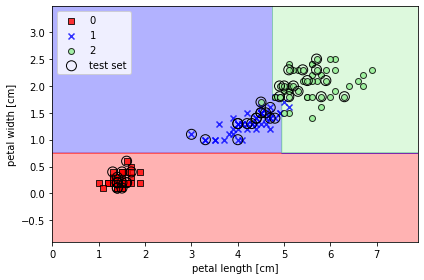

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

For curiosity's sake, notive that tt is possible to export the image above to a file. See below.

In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png')

# Decision trees for regression

Decision trees can also be used in a regression task. However, in this case, an impurity metric suitable for continuous variables (instead of Gini index and information gain) should be used. Also, the value predicted by a leaf node in a regression tree is the average of the target values for the examples inside that leaf.

One possible metric is the mean squared error (MSE). In particular, to quantify the level of impurity $I(t)$ in a node $t$ of the decision tree being built, we can apply the following expression:

$$
I(t) = \operatorname{MSE}(t) = \frac{1}{m_t}  \sum_{i \in D_t} (y^{(i)} - \overline{y}_t)^2
$$

$$
\overline{y}_t = \frac{1}{m_t} \sum_{i \in D_t} y^{(i)}
$$

In the expressions above:

* $D_t$ is the training subset at node $t$.

* $m_t$ is the size of $D_t$ (i.e., the number of training examples at node $t$).

* $y^{(i)}$ is the true value of the target feature for the $i$-th training example in $D_t$.

* $\overline{y}_t$ is the average of the predicted values for examples  in $D_t$.

Source: Python Machine Learning, 2nd ed., pp 341

In [ ]:
import numpy as np
expl = np.array([2.5, 2.5, 2.5, 2.5])
print(expl.mean())

4.25


The following example illustrates the use of the class [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), present in Scikit-Learn to induce decision tree models for regression.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets

# Load data with only two features
boston = datasets.load_boston()
X = boston.data[:,0:2]
y = boston.target

# Create decision tree classifer object
regr = DecisionTreeRegressor(random_state=0)

# Train model
model = regr.fit(X, y)

# Make new observation
observation = [[0.02, 16]]
              
# Predict observation's value  
print(model.predict(observation))

[33.]


The following code ([source](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py)) provides another example of using the class `DecisionTreeRegressor`. Notice that, if the maximum depth of the tree (controlled by the parameter `max_depth`) is set too high, the decision trees learns very fine details from the training data and learns from the noise, that is, they overfit.

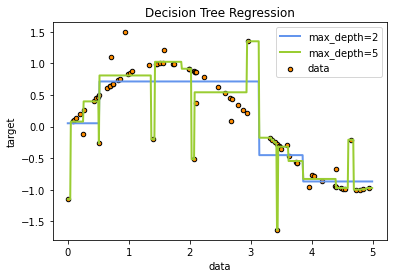

In [ ]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit two regression models
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

# Final Remarks

Some advantages of decision tree models are:

* They are simple to understand and interpret. Trees can be viewed.

* They require little data preparation. Other techniques usually require data normalization, dummy variables need to be created.

* The cost of using the tree (ie, predicting data) is logarithmic in the number of data points used to train the tree.

* They are able to handle numerical and categorical data. Other learning techniques are generally specialized in the analysis of data sets that have only one type of variable. 
